In [ ]:
import glob
import json
import os

import numpy as np
from matplotlib import pyplot as plt

## All benchmarks, all hyperparameters are learned

In [ ]:

benchmarks = ['branin2', 'hartmann6', 'rover', 'mopta08',
              'prior_sample_2d_ls0.5', 'prior_sample_2d_ls1', 'prior_sample_2d_ls2',
              'prior_sample_50d_ls0.5', 'prior_sample_50d_ls1', 'prior_sample_50d_ls2',
              'prior_sample_100d_ls0.5', 'prior_sample_100d_ls1', 'prior_sample_100d_ls2',
              'levy300', 'levy500', 'schwefel300', 'schwefel500', 'griewank300', 'griewank500', 'lasso-high',
              'lasso-hard', 'lasso-dna', 'svm']


run_dirs_ves = glob.glob('../results/rerun_ves_nov_22_w_noise/*')
run_dirs_ei = glob.glob('../results/rerun_ei_nov_22_w_noise/*')
run_dirs_mes = glob.glob('../results/rerun_mes_dec_1_w_noise/*')

NUM_PATHS = 128

for benchmark in benchmarks:

    def general_dir_match(
            args: dict,
    ):
        if not 'prior_sample' in benchmark:
            return True
        else:
            ls = float(benchmark.split('_')[-1][2:])
            set_ls = args['set_lengthscale']
            return set_ls is None  # and float(ls) == float(set_ls)


    def filter_and_append_relevant(
            dirr
    ):
        def _filter_relevant(
                _dirr
        ):
            return [d for d in _dirr if 'args.json' in os.listdir(d) and json.load(open(f'{d}/args.json'))['benchmark'] == benchmark]

        filtered = _filter_relevant(
            dirr
        )
        return filtered


    def remove_old_results(
            dirr
    ):
        rerun_dirs = [d for d in dirr if 'rerun' in d]
        if len(rerun_dirs) > 0:
            return rerun_dirs
        else:
            return dirr


    if benchmark in benchmarks:
        relevant_dirs = filter_and_append_relevant(run_dirs_ves+run_dirs_mes+run_dirs_ei)
        relevant_dirs = [d for d in relevant_dirs if general_dir_match(json.load(open(f'{d}/args.json')))]

        ves_dirs = [d for d in relevant_dirs if f'{d}/train_x_ves.npy' in glob.glob(f'{d}/*') and not json.load(open(f'{d}/args.json'))['exponential_family']]
        ei_dirs = [d for d in relevant_dirs if f'{d}/train_x_ei.npy' in glob.glob(f'{d}/*')]
        mes_dirs = [d for d in relevant_dirs if f'{d}/train_x_mes.npy' in glob.glob(f'{d}/*')]

        # if there are rerun results, throw out the old ones
        ves_dirs = remove_old_results(ves_dirs)
        ei_dirs = remove_old_results(ei_dirs)
        mes_dirs = remove_old_results(mes_dirs)

    # relevant_dirs_2 = [d for d in run_dirs_2 if json.load(open(f'{d}/args.json'))['benchmark'] == benchmark]
    # relevant_dirs_2 = [d for d in relevant_dirs_2 if general_dir_match(json.load(open(f'{d}/args.json')))]
    # relevant_dirs_17 = [d for d in run_dirs_17 if json.load(open(f'{d}/args.json'))['benchmark'] == benchmark]
    # relevant_dirs_17 = [d for d in relevant_dirs_17 if general_dir_match(json.load(open(f'{d}/args.json')))]
    # relevant_dirs_25 = [d for d in run_dirs_25 if json.load(open(f'{d}/args.json'))['benchmark'] == benchmark]
    # relevant_dirs_25 = [d for d in relevant_dirs_25 if general_dir_match(json.load(open(f'{d}/args.json')))]

    # ei_dirs = [d for d in relevant_dirs_2 if f'{d}/train_x_ei.npy' in glob.glob(f'{d}/*')]
    # mes_dirs = [d for d in relevant_dirs_2 if f'{d}/train_x_mes.npy' in glob.glob(f'{d}/*')]
    # if benchmark in prior_benchmarks:
    #     ves_dirs = [d for d in relevant_dirs_17 if json.load(open(f'{d}/args.json'))['num_paths'] == NUM_PATHS]
    # else:
    #     ves_dirs = [d for d in relevant_dirs_2 if json.load(open(f'{d}/args.json'))['num_paths'] == 128]
    print(benchmark)
    fig, ax = plt.subplots(figsize=(5, 3))
    ax2 = ax.twinx()

    ves_y = [np.maximum.accumulate(np.load(f'{d}/train_y_ves.npy')) for d in ves_dirs]
    if len(ves_y) == 0:
        print('VES missing')
    else:
        min_len = min([len(y) for y in ves_y])
        ves_y = [y[:min_len] for y in ves_y]
        ves_y = -np.stack(ves_y).squeeze(-1)
        ves_y_mean = ves_y.mean(axis=0)
        ves_y_std = ves_y.std(axis=0) / np.sqrt(len(ves_y))
        ax.plot(ves_y_mean, label='VES-Gamma', color='blue', linestyle='--')
        ax.fill_between(
            np.arange(len(ves_y_mean)),
            ves_y_mean - ves_y_std,
            ves_y_mean + ves_y_std,
            alpha=0.2,
            color='blue'
        )

    ei_y = [np.maximum.accumulate(np.load(f'{d}/train_y_ei.npy')) for d in ei_dirs]
    if len(ei_y) == 0:
        print('EI missing')
    else:
        min_len = min([len(y) for y in ei_y])
        ei_y = [y[:min_len] for y in ei_y]
        ei_y = -np.stack(ei_y).squeeze(-1)
        ei_y_mean = ei_y.mean(axis=0)
        ei_y_std = ei_y.std(axis=0) / np.sqrt(len(ei_y))
        ax.plot(ei_y_mean, label='EI', color='black', linestyle='--')
        ax.fill_between(np.arange(len(ei_y_mean)), ei_y_mean - ei_y_std, ei_y_mean + ei_y_std, alpha=0.2, color='black')

    mes_y = [np.maximum.accumulate(np.load(f'{d}/train_y_mes.npy')) for d in mes_dirs]
    if len(mes_y) == 0:
        print('MES missing')
    else:
        min_len = min([len(y) for y in mes_y])
        mes_y = [y[:min_len] for y in mes_y]
        mes_y = -np.stack(mes_y).squeeze(-1)
        mes_y_mean = mes_y.mean(axis=0)
        mes_y_std = mes_y.std(axis=0) / np.sqrt(len(mes_y))
        ax.plot(mes_y_mean, label='MES', color='red', linestyle='--')
        ax.fill_between(
            np.arange(len(mes_y_mean)),
            mes_y_mean - mes_y_std,
            mes_y_mean + mes_y_std,
            alpha=0.2,
            color='red'
        )

    ax.legend()
    ax.set_title(f'{benchmark}')
    if benchmark == 'branin2':
        ax.set_yscale('log')
    if benchmark.startswith('prior_sample'):
        # find best value
        ax.set_yscale('symlog')
    ax.set_xlim(0, 1000)
    # fig.savefig(f'figs/gp_prior/learn/{benchmark}.pdf', format='pdf', bbox_inches='tight', dpi=100)
    plt.show()



## Prior sample benchmarks, hyperparameters are set to the correct value

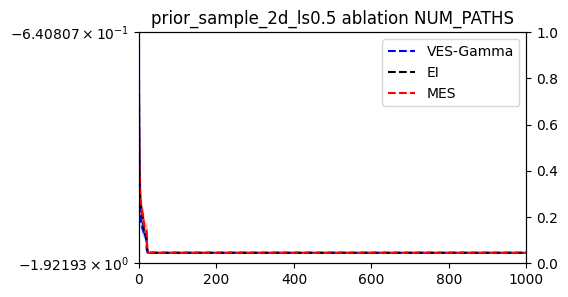

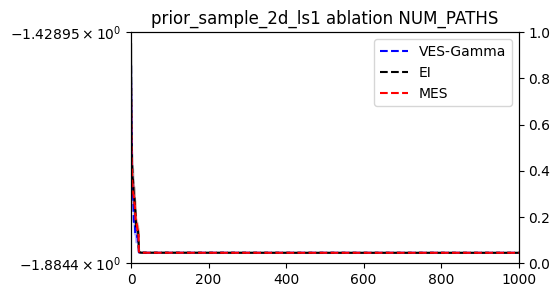

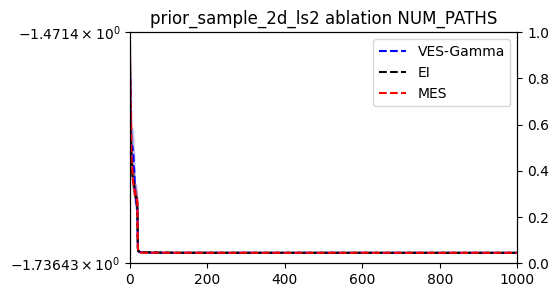

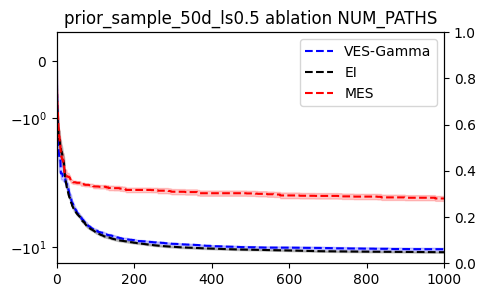

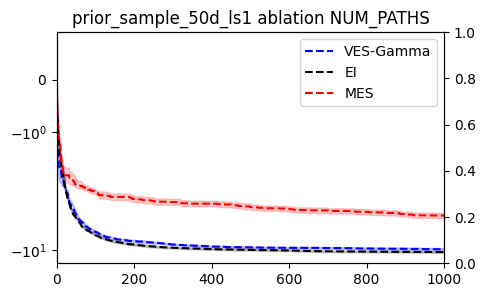

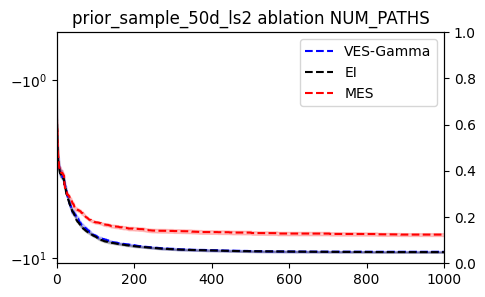

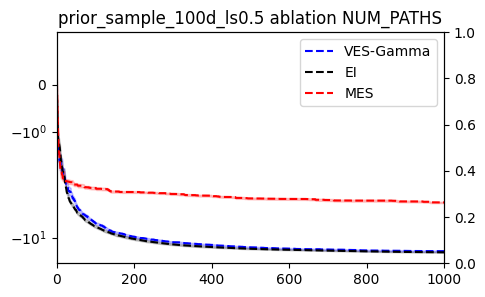

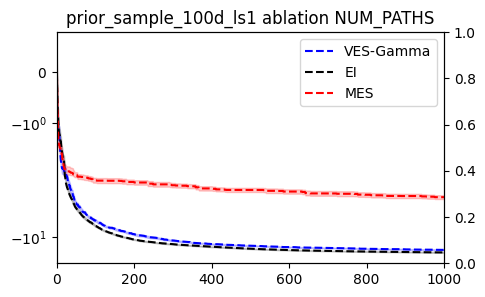

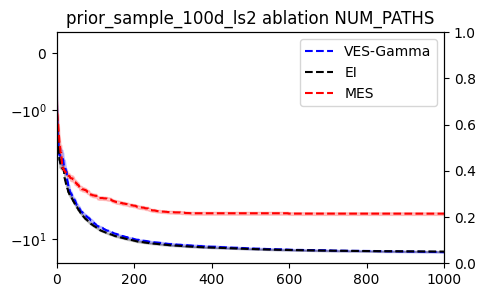

In [3]:
benchmarks = ['prior_sample_2d_ls0.5', 'prior_sample_2d_ls1', 'prior_sample_2d_ls2',
              'prior_sample_50d_ls0.5', 'prior_sample_50d_ls1', 'prior_sample_50d_ls2',
              'prior_sample_100d_ls0.5', 'prior_sample_100d_ls1', 'prior_sample_100d_ls2']


run_dirs_ves = glob.glob('../results/rerun_ves_nov_22_w_noise/*')
run_dirs_ei = glob.glob('../results/rerun_ei_nov_22_w_noise/*')
run_dirs_mes = glob.glob('../results/rerun_mes_dec_1_w_noise/*')

run_dirs = run_dirs_ei + run_dirs_ves + run_dirs_mes


for benchmark in benchmarks:
    try:
        def general_dir_match(
                args: dict,
        ):
            if not 'prior_sample' in benchmark:
                return True
            else:
                ls = float(benchmark.split('_')[-1][2:])
                set_ls = args['set_lengthscale']
                return set_ls is not None and set_ls == ls


        if benchmark in benchmarks:
            relevant_dirs = [d for d in run_dirs if json.load(open(f'{d}/args.json'))['benchmark'] == benchmark]
            relevant_dirs = [d for d in relevant_dirs if general_dir_match(json.load(open(f'{d}/args.json')))]

            ei_dirs = [d for d in relevant_dirs if f'{d}/train_x_ei.npy' in glob.glob(f'{d}/*')]
            mes_dirs = [d for d in relevant_dirs if f'{d}/train_x_mes.npy' in glob.glob(f'{d}/*')]
            ves_dirs = [d for d in relevant_dirs if f'{d}/train_x_ves.npy' in glob.glob(f'{d}/*') and not json.load(open(f'{d}/args.json'))['exponential_family']]

        # ablation NUM_PATHS
        fig, ax = plt.subplots(figsize=(5, 3))
        ax2 = ax.twinx()

        ves_y = [np.maximum.accumulate(np.load(f'{d}/train_y_ves.npy')) for d in ves_dirs]
        min_len = min([len(y) for y in ves_y])
        ves_y = [y[:min_len] for y in ves_y]
        ves_y = -np.stack(ves_y).squeeze(-1)
        ves_y_mean = ves_y.mean(axis=0)
        ves_y_std = ves_y.std(axis=0) / np.sqrt(len(ves_y))

        ei_y = [np.maximum.accumulate(np.load(f'{d}/train_y_ei.npy')) for d in ei_dirs]
        min_len = min([len(y) for y in ei_y])
        ei_y = [y[:min_len] for y in ei_y]
        ei_y = -np.stack(ei_y).squeeze(-1)
        ei_y_mean = ei_y.mean(axis=0)
        ei_y_std = ei_y.std(axis=0) / np.sqrt(len(ei_y))

        mes_y = [np.maximum.accumulate(np.load(f'{d}/train_y_mes.npy')) for d in mes_dirs]
        min_len = min([len(y) for y in mes_y])
        mes_y = [y[:min_len] for y in mes_y]
        mes_y = -np.stack(mes_y).squeeze(-1)
        mes_y_mean = mes_y.mean(axis=0)
        mes_y_std = mes_y.std(axis=0) / np.sqrt(len(mes_y))

        ax.plot(ves_y_mean, label='VES-Gamma', color='blue', linestyle='--')
        ax.fill_between(np.arange(len(ves_y_mean)), ves_y_mean - ves_y_std, ves_y_mean + ves_y_std, alpha=0.2, color='blue')

        ax.plot(ei_y_mean, label='EI', color='black', linestyle='--')
        ax.fill_between(np.arange(len(ei_y_mean)), ei_y_mean - ei_y_std, ei_y_mean + ei_y_std, alpha=0.2, color='black')

        ax.plot(mes_y_mean, label='MES', color='red', linestyle='--')
        ax.fill_between(np.arange(len(mes_y_mean)), mes_y_mean - mes_y_std, mes_y_mean + mes_y_std, alpha=0.2, color='red')

        ax.legend()
        ax.set_title(f'{benchmark} ablation NUM_PATHS')
        if benchmark == 'branin2':
            ax.set_yscale('log')
        if benchmark.startswith('prior_sample'):
            # find best value
            ax.set_yscale('symlog')
        ax.set_xlim(0, 1000)
        # fig.savefig(f'figs/gp_prior/correct/{benchmark}.pdf', format='pdf', bbox_inches='tight', dpi=100)

        plt.show()
    except Exception as e:
        print(f"error for {benchmark}: {e}")



## Prior sample benchmarks, hyperparameters are set to two times the correct value

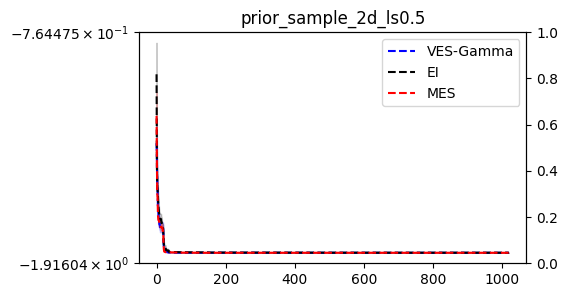

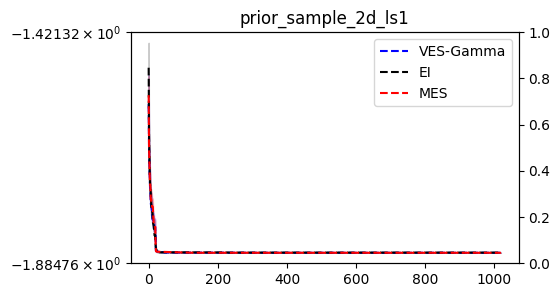

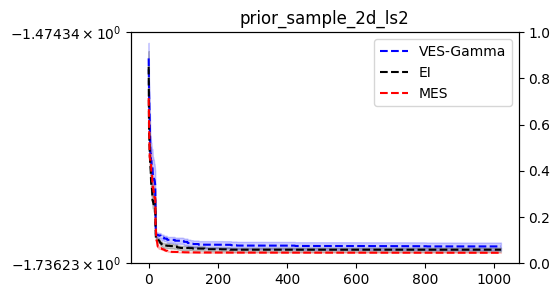

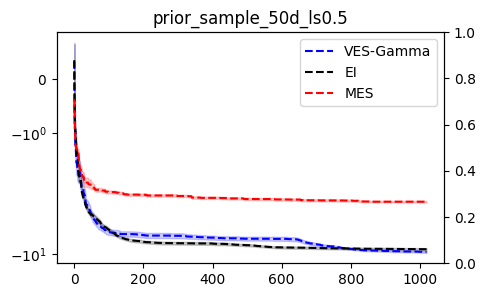

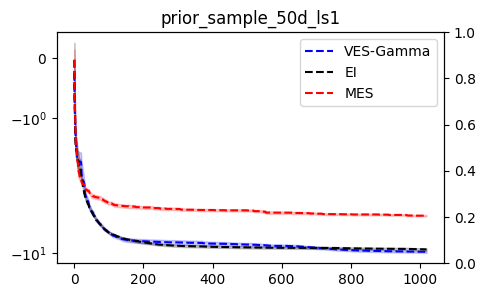


KeyboardInterrupt



In [4]:
benchmarks = ['prior_sample_2d_ls0.5', 'prior_sample_2d_ls1', 'prior_sample_2d_ls2',
              'prior_sample_50d_ls0.5', 'prior_sample_50d_ls1', 'prior_sample_50d_ls2',
              'prior_sample_100d_ls0.5', 'prior_sample_100d_ls1', 'prior_sample_100d_ls2']

run_dirs_ves = glob.glob('../results/rerun_ves_nov_22_w_noise/*')
run_dirs_ei = glob.glob('../results/rerun_ei_nov_22_w_noise/*')
run_dirs_mes = glob.glob('../results/rerun_mes_dec_1_w_noise/*')

run_dirs = run_dirs_ei + run_dirs_ves + run_dirs_mes

for benchmark in benchmarks:

    def general_dir_match(
            args: dict,
    ):
        if not 'prior_sample' in benchmark:
            return True
        else:
            ls = float(benchmark.split('_')[-1][2:])
            set_ls = args['set_lengthscale']
            return set_ls is not None and set_ls != ls


    if benchmark in benchmarks:
        relevant_dirs = [d for d in run_dirs if json.load(open(f'{d}/args.json'))['benchmark'] == benchmark]
        relevant_dirs = [d for d in relevant_dirs if general_dir_match(json.load(open(f'{d}/args.json')))]

        mes_dirs = [d for d in relevant_dirs if f'{d}/train_x_mes.npy' in glob.glob(f'{d}/*')]
        ei_dirs = [d for d in relevant_dirs if f'{d}/train_x_ei.npy' in glob.glob(f'{d}/*')]
        ves_dirs = [d for d in relevant_dirs if f'{d}/train_x_ves.npy' in glob.glob(f'{d}/*') and not json.load(open(f'{d}/args.json'))['exponential_family']]

    fig, ax = plt.subplots(figsize=(5, 3))
    ax2 = ax.twinx()


    ves_y = [np.maximum.accumulate(np.load(f'{d}/train_y_ves.npy')) for d in ves_dirs]
    min_len = min([len(y) for y in ves_y])
    ves_y = [y[:min_len] for y in ves_y]
    ves_y = -np.stack(ves_y).squeeze(-1)
    ves_y_mean = ves_y.mean(axis=0)
    ves_y_std = ves_y.std(axis=0) / np.sqrt(len(ves_y))

    ei_y = [np.maximum.accumulate(np.load(f'{d}/train_y_ei.npy')) for d in ei_dirs]
    min_len = min([len(y) for y in ei_y])
    ei_y = [y[:min_len] for y in ei_y]
    ei_y = -np.stack(ei_y).squeeze(-1)
    ei_y_mean = ei_y.mean(axis=0)
    ei_y_std = ei_y.std(axis=0) / np.sqrt(len(ei_y))

    mes_y = [np.maximum.accumulate(np.load(f'{d}/train_y_mes.npy')) for d in mes_dirs]
    min_len = min([len(y) for y in mes_y])
    mes_y = [y[:min_len] for y in mes_y]
    mes_y = -np.stack(mes_y).squeeze(-1)
    mes_y_mean = mes_y.mean(axis=0)
    mes_y_std = mes_y.std(axis=0) / np.sqrt(len(mes_y))

    ax.plot(ves_y_mean, label='VES-Gamma', color='blue', linestyle='--')
    ax.fill_between(np.arange(len(ves_y_mean)), ves_y_mean - ves_y_std, ves_y_mean + ves_y_std, alpha=0.2, color='blue')

    ax.plot(ei_y_mean, label='EI', color='black', linestyle='--')
    ax.fill_between(np.arange(len(ei_y_mean)), ei_y_mean - ei_y_std, ei_y_mean + ei_y_std, alpha=0.2, color='black')

    ax.plot(mes_y_mean, label='MES', color='red', linestyle='--')
    ax.fill_between(np.arange(len(mes_y_mean)), mes_y_mean - mes_y_std, mes_y_mean + mes_y_std, alpha=0.2, color='red')

    ax.legend()
    ax.set_title(f'{benchmark}')
    if benchmark == 'branin2':
        ax.set_yscale('log')
    if benchmark.startswith('prior_sample'):
        # find best value
        ax.set_yscale('symlog')
    #ax.set_xlim(0, 1000)
    # fig.savefig(f'figs/gp_prior/twoCorrect/{benchmark}.pdf', format='pdf', bbox_inches='tight', dpi=100)

    plt.show()

